# **Exploratory Data Analysis**

## Objectives

* Examine the data:
  1. Understand the columns of the tabular dataset
  2. Understand the dependent variable
  3. Understand relationships between dependent and independent variables

## Inputs

Downloaded from https://www.kaggle.com/datasets/codeinstitute/housing-prices-data

* house_prices_records: main data set on which model to be trained, contains 24 columns and 1460 rows
* inherited_houses: data set on which predictions need to be performed, contains 23 columns (same as the house price records except for the dependent variable) and 4 rows
* house-metadata: data description

## Outputs

* List 

## Additional Comments

* The inputs are read from the local filesystem. Another script downloads the inputs.


# 0: Notebook Setup

Import libraries

In [1]:
import os
import dotenv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

All file paths are saved as environment variables. Load environment variables.

In [2]:
dotenv.load_dotenv()

True

Define input paths

In [3]:
data_dictionary_path = os.path.join(os.getenv("LOCAL_DATASET_PATH"), os.getenv("HOUSING_DATA_DICTIONARY"))
housing_records_path = os.path.join(os.getenv("DATASET_FILE_PATH"), os.getenv("HOUSING_RECORDS_FILENAME"))
inherited_houses_path = os.path.join(os.getenv("DATASET_FILE_PATH"), os.getenv("INHERITED_HOUSES_FILENAME"))

In [4]:
housing_records_rows, housing_records_columns = 1460, 24

# 1: Data Understanding

# 1.0 Data Metadata

In [5]:
column_descriptions = {}

with open(data_dictionary_path) as file_read:
    for line in file_read:
        print(line.strip("\n"))
        if not line.startswith(" "):
            label, description = line.strip("\n").split(":")
            column_descriptions[label] = description.strip()

1stFlrSF: First Floor square feet
    334 - 4692
2ndFlrSF: Second floor square feet
    0 - 2065
BedroomAbvGr: Bedrooms above grade (does NOT include basement bedrooms)
    0 - 8
BsmtExposure: Refers to walkout or garden level walls
    Gd: Good Exposure;
    Av: Average Exposure;
    Mn: Mimimum Exposure;
    No: No Exposure;
    None: No Basement
BsmtFinType1: Rating of basement finished area
    GLQ: Good Living Quarters;
    ALQ: Average Living Quarters;
    BLQ: Below Average Living Quarters;
    Rec: Average Rec Room;
    LwQ: Low Quality;
    Unf: Unfinshed;
    None: No Basement
BsmtFinSF1: Type 1 finished square feet
    0 - 5644
BsmtUnfSF: Unfinished square feet of basement area
    0 - 2336
TotalBsmtSF: Total square feet of basement area
    0 - 6110
GarageArea: Size of garage in square feet
    0 - 1418
GarageFinish: Interior finish of the garage
    Fin: Finished;
    RFn: Rough Finished;
    Unf: Unfinished;
    None: No Garage
GarageYrBlt: Year garage was built
    1900 

In [6]:
categorical_columns = [
    "BedroomAbvGr", 
    "BsmtExposure", 
    "BsmtFinType1", 
    "GarageFinish", 
    "KitchenQual", 
    "OverallCond", 
    "OverallQual"
]

year_columns = [
    "GarageYrBlt",
    "YearBuilt",
    "YearRemodAdd"
]

## 1.1 Housing Records dataset

In [7]:
housing_records = pd.read_csv(housing_records_path)
assert housing_records.shape == (housing_records_rows, housing_records_columns)

### 1.1 Handling missing values

In [36]:
na_data = pd.DataFrame(housing_records.isna().sum(), columns=["count"])
na_data["percentage"] = round(na_data["count"] / housing_records_rows * 100, 2)
na_data["should_remove"] = na_data["percentage"] >= 10
na_data = na_data.convert_dtypes().sort_values(by="count", ascending=False)
na_data.loc[["total", "total_fraction"]] = [
    na_data["count"].sum(),
    round(100 * na_data["count"].sum()/(housing_records_columns * housing_records_rows), 2)
]
display(na_data)

ValueError: cannot set a row with mismatched columns

In [9]:
columns_missing_data = na_data[na_data["should_remove"]].index
columns_to_keep = housing_records.columns.difference(set(columns_missing_data))
categorical_columns = set(categorical_columns).difference(columns_missing_data)
year_columns = set(year_columns).difference(columns_missing_data)

In [10]:
housing_records = housing_records[columns_to_keep]
housing_records.shape

(1460, 20)

In [11]:
separator = 6
for _ in range(4):
    print(housing_records[housing_records.columns[_ * separator:(_+1) * separator]].head(5))
    print()

   1stFlrSF  2ndFlrSF  BedroomAbvGr BsmtExposure  BsmtFinSF1 BsmtFinType1
0       856     854.0           3.0           No         706          GLQ
1      1262       0.0           3.0           Gd         978          ALQ
2       920     866.0           3.0           Mn         486          GLQ
3       961       NaN           NaN           No         216          ALQ
4      1145       NaN           4.0           Av         655          GLQ

   BsmtUnfSF  GarageArea  GarageYrBlt  GrLivArea KitchenQual  LotArea
0        150         548       2003.0       1710          Gd     8450
1        284         460       1976.0       1262          TA     9600
2        434         608       2001.0       1786          Gd    11250
3        540         642       1998.0       1717          Gd     9550
4        490         836       2000.0       2198          Gd    14260

   MasVnrArea  OpenPorchSF  OverallCond  OverallQual  SalePrice  TotalBsmtSF
0       196.0           61            5            7     

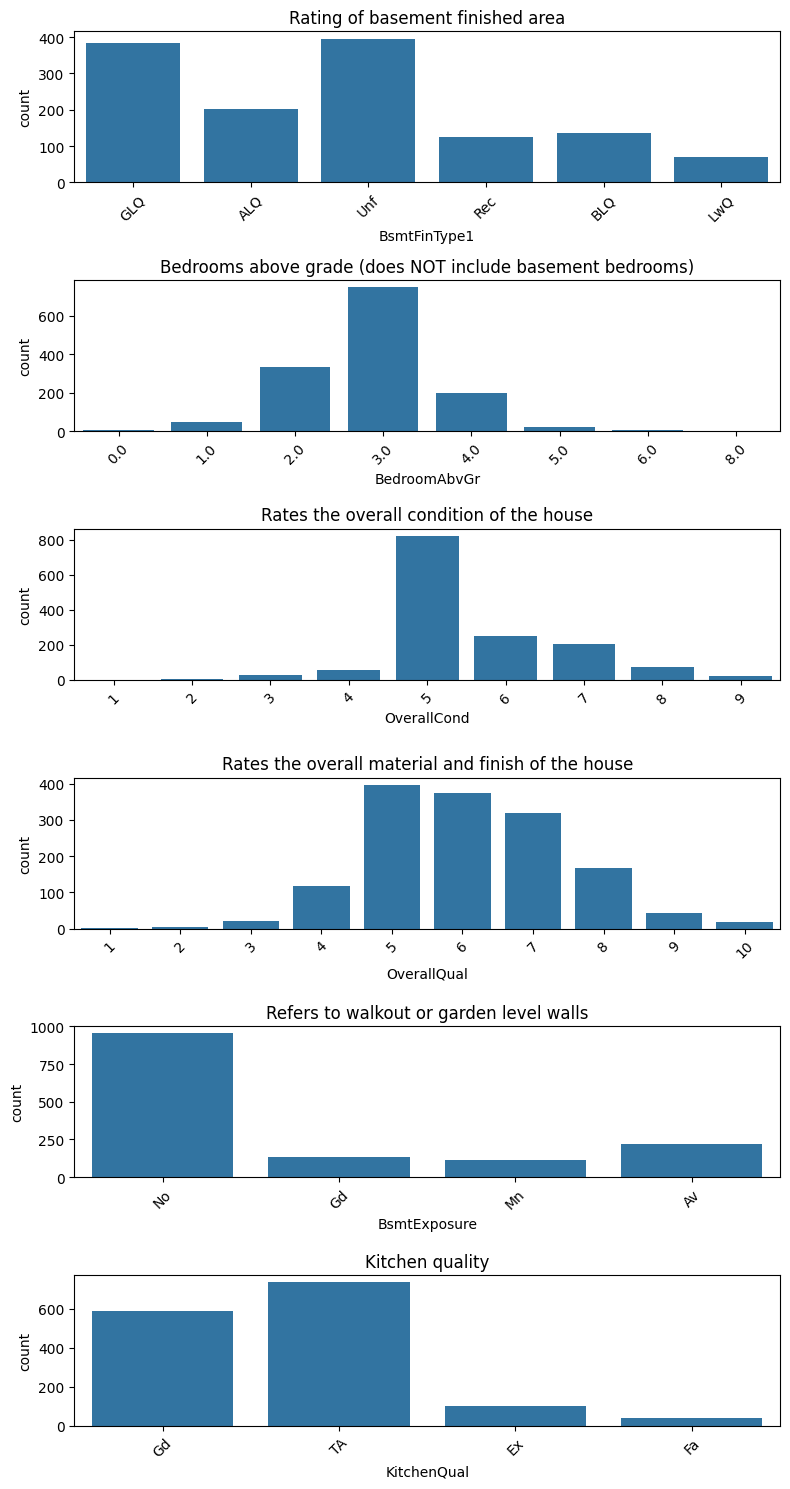

In [12]:
column_count = int(len(categorical_columns))

fig, axs = plt.subplots(column_count, figsize = (8, 2.5 * column_count))

for idx, var in enumerate(categorical_columns):
    ax = axs[idx]
    sns.countplot(data=housing_records, x=var, ax=ax)
    ax.set_title(f"{column_descriptions[var]}")
    ax.set_xlabel(var)
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

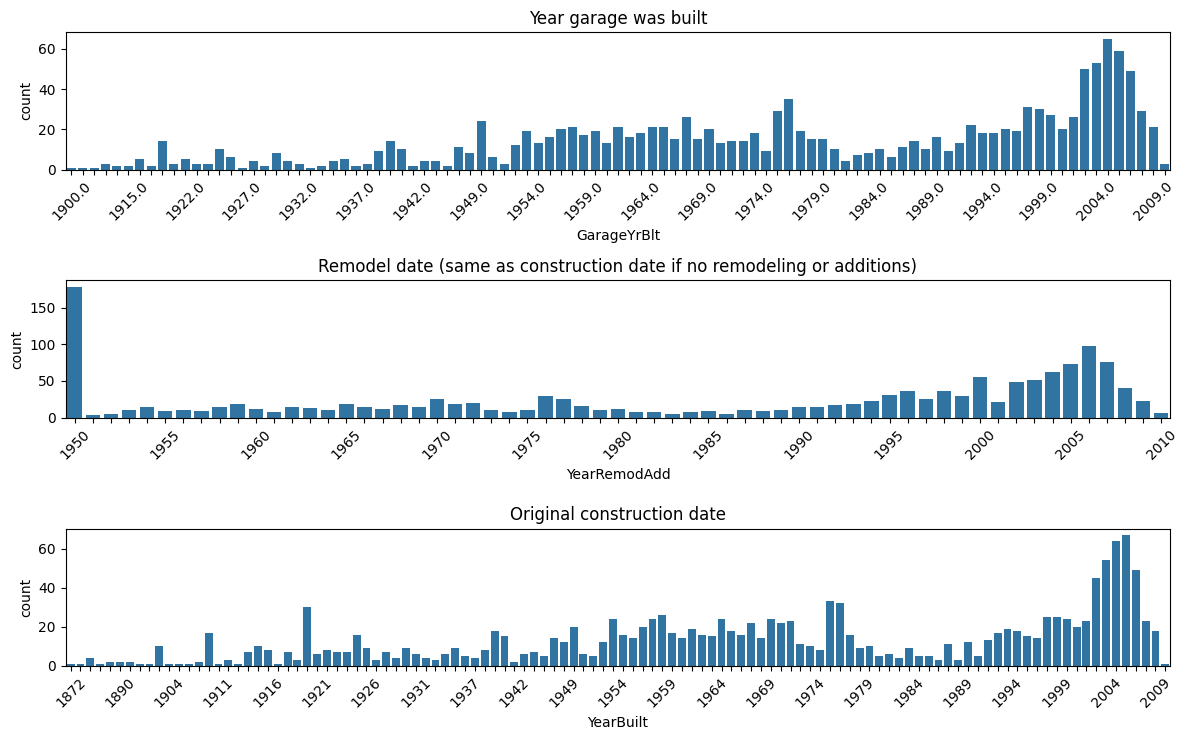

In [13]:
column_count = int(len(year_columns))
fig, axs = plt.subplots(column_count, figsize = (12, 2.5 * column_count))
every_nth_year = 5
for idx, var in enumerate(year_columns):
    ax = axs[idx]
    sns.countplot(data=housing_records, x=var, ax=ax)
    ax.set_title(f"{column_descriptions[var]}")
    ax.set_xlabel(var)
    ax.tick_params(axis='x', rotation=45)
    if var in year_columns:
        for n, label in enumerate(ax.xaxis.get_ticklabels()):
            if n % every_nth_year != 0:
                label.set_visible(False)

plt.tight_layout()
plt.show()

In [14]:
other_columns = list(
    housing_records.columns.difference(categorical_columns).difference(year_columns)
)
other_columns

['1stFlrSF',
 '2ndFlrSF',
 'BsmtFinSF1',
 'BsmtUnfSF',
 'GarageArea',
 'GrLivArea',
 'LotArea',
 'MasVnrArea',
 'OpenPorchSF',
 'SalePrice',
 'TotalBsmtSF']

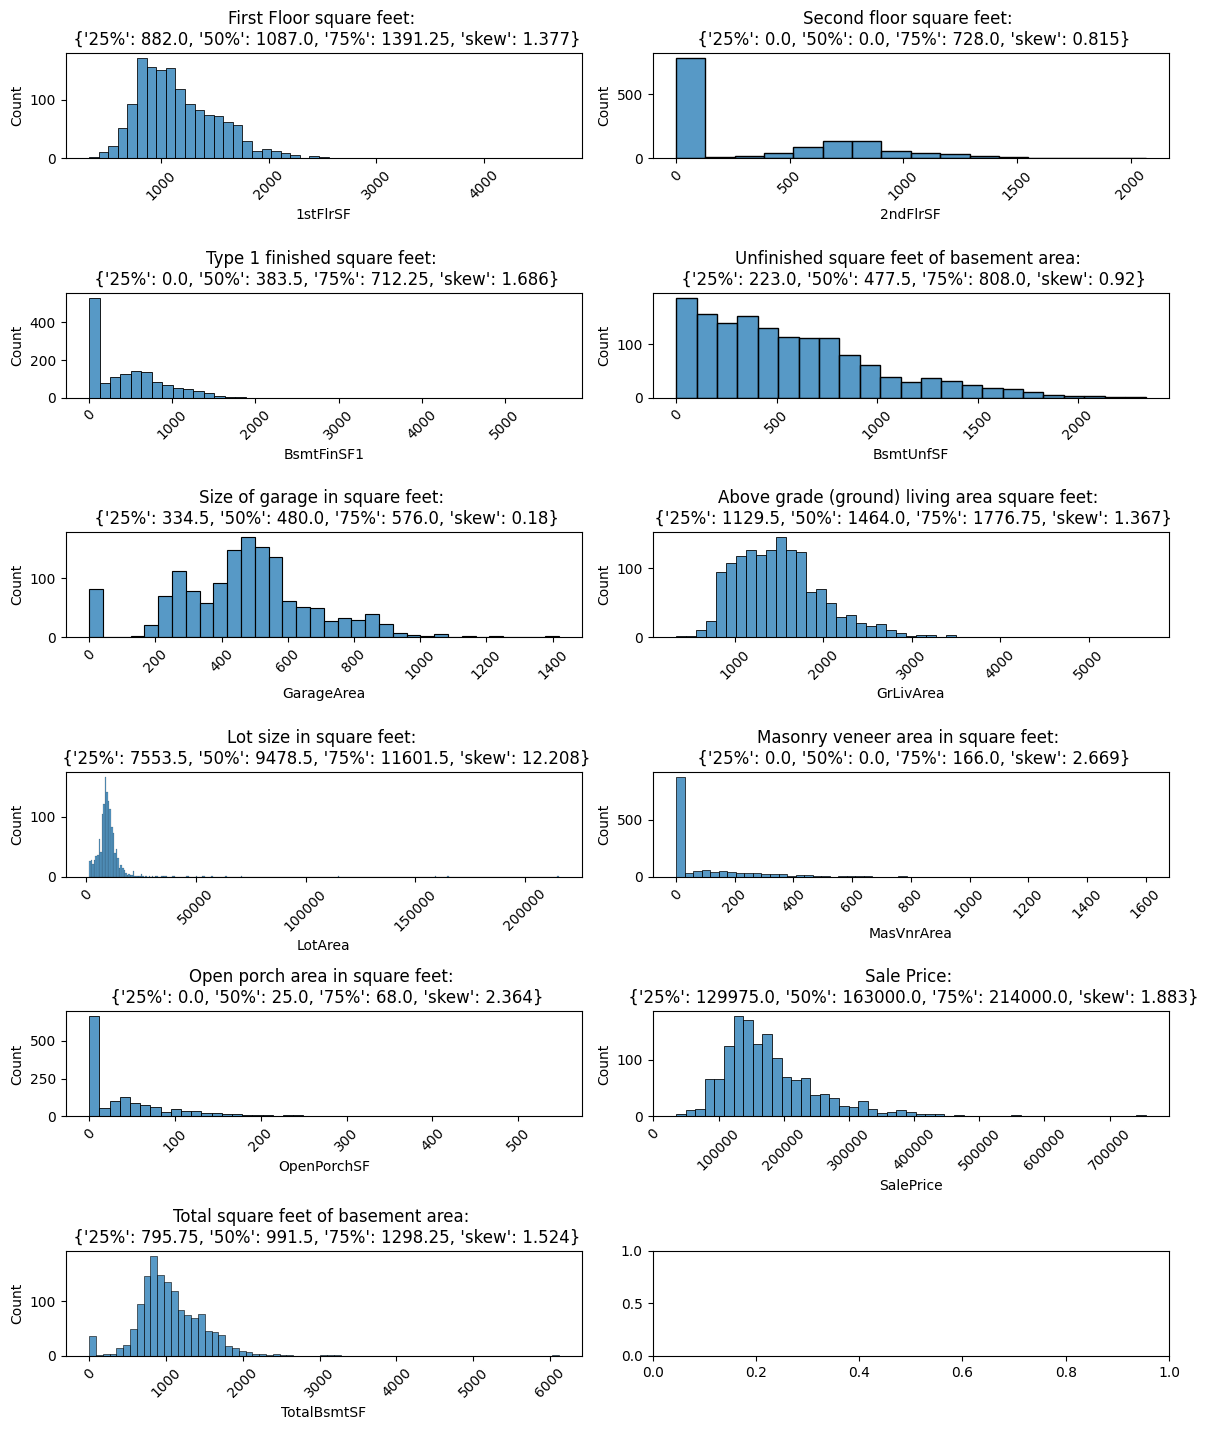

In [15]:
column_count = int(len(other_columns))
if column_count % 2 == 1:
    column_count = column_count + 1
    
plot_columns = 2
fig, axs = plt.subplots(int(column_count/plot_columns), plot_columns, figsize = (12, 1.2 * column_count))

for idx, var in enumerate(other_columns):
    ax = axs[int(idx / plot_columns)][idx % plot_columns]
    stats = housing_records[var].describe().loc[["25%", "50%", "75%"]]
    stats.loc["skew"] = round(housing_records[var].skew(), 3)
    sns.histplot(data=housing_records, x=var, ax=ax)
    ax.set_title(f"{column_descriptions[var]}: \n {stats.to_dict()}")
    ax.set_xlabel(var)
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## 1.1 Inherited houses dataset

In [16]:
inherited_houses = pd.read_csv(inherited_houses_path)
assert inherited_houses.shape == (4, 23)
inherited_houses.head()

,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,EnclosedPorch,GarageArea,GarageFinish,...,LotArea,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd
0,896,0,2,No,468.0,Rec,270.0,0,730.0,Unf,...,11622,80.0,0.0,0,6,5,882.0,140,1961,1961
1,1329,0,3,No,923.0,ALQ,406.0,0,312.0,Unf,...,14267,81.0,108.0,36,6,6,1329.0,393,1958,1958
2,928,701,3,No,791.0,GLQ,137.0,0,482.0,Fin,...,13830,74.0,0.0,34,5,5,928.0,212,1997,1998
3,926,678,3,No,602.0,GLQ,324.0,0,470.0,Fin,...,9978,78.0,20.0,36,6,6,926.0,360,1998,1998


In [17]:
inherited_houses.columns

Index(['1stFlrSF', '2ndFlrSF', 'BedroomAbvGr', 'BsmtExposure', 'BsmtFinSF1',
       'BsmtFinType1', 'BsmtUnfSF', 'EnclosedPorch', 'GarageArea',
       'GarageFinish', 'GarageYrBlt', 'GrLivArea', 'KitchenQual', 'LotArea',
       'LotFrontage', 'MasVnrArea', 'OpenPorchSF', 'OverallCond',
       'OverallQual', 'TotalBsmtSF', 'WoodDeckSF', 'YearBuilt',
       'YearRemodAdd'],
      dtype='object')

## 1.4 Target Variable

In [18]:
target_variable = set(housing_records.columns).difference(set(inherited_houses.columns)).pop()
target_variable

'SalePrice'

# 2: Univariate Analysis

## 2.1: Analysis of `SalePrice`

In [19]:
sale_prices = housing_records[target_variable]

In [20]:
sale_prices.describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

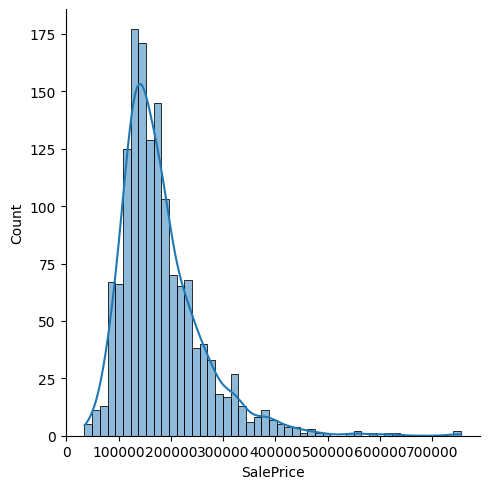

In [21]:
sns.displot(sale_prices, kde=True)

Skewness and Kurtosis

In [22]:
f"Skewness: {sale_prices.skew()}, Kurtosis: {sale_prices.kurt()}" 

'Skewness: 1.8828757597682129, Kurtosis: 6.536281860064529'

## 2.2 Co-variance of SalePrice with Numerical variables

In [23]:
def get_correlations(target_values, variating_values, target_variable, variating_name):
    corr = pd.concat([target_values, variating_values], axis=1).corr()
    corr_value = corr[variating_name].iloc[0]
    if corr.isnull().sum().sum() > 0:
        corr_description = "no correlation"
    elif var == target_variable:
        corr_description = "not applicable"
        corr_value = 1.0
    else:
        if corr_value < 0.3:
            corr_description = "very weak correlation"
        elif 0.3 <= corr_value < 0.5:
            corr_description = "weak correlation"
        elif 0.5 <= corr_value < 0.7:
            corr_description = "moderate correlation"
        else:
            corr_description = "strong correlation"
    
    return corr_value, corr_description

In [24]:
numerical_columns = housing_records.columns.difference(categorical_columns).difference(set(target_variable))
numerical_column_count = len(numerical_columns)

In [25]:
correlation_data = []
for idx, var in enumerate(numerical_columns):
    corr_value, corr_description = get_correlations(target_values=sale_prices, 
                                                    variating_values=housing_records[var], 
                                                    target_variable=target_variable, 
                                                    variating_name=var)
    
    
    correlation_data.append([var, corr_value, corr_description]) 

correlation_info = {
    var: [value, desc]
    for var, value, desc in sorted(correlation_data, key=lambda item: item[1], reverse=True)    
}
correlation_info

{'SalePrice': [1.0, 'not applicable'],
 'GrLivArea': [0.7086244776126517, 'strong correlation'],
 'GarageArea': [0.6234314389183622, 'moderate correlation'],
 'TotalBsmtSF': [0.6135805515591942, 'moderate correlation'],
 '1stFlrSF': [0.6058521846919153, 'moderate correlation'],
 'YearBuilt': [0.522897332879497, 'moderate correlation'],
 'YearRemodAdd': [0.5071009671113869, 'moderate correlation'],
 'GarageYrBlt': [0.48636167748785925, 'weak correlation'],
 'MasVnrArea': [0.47749304709571455, 'weak correlation'],
 'BsmtFinSF1': [0.38641980624215344, 'weak correlation'],
 '2ndFlrSF': [0.3223353146677458, 'weak correlation'],
 'OpenPorchSF': [0.31585622711605504, 'weak correlation'],
 'LotArea': [0.2638433538714051, 'very weak correlation'],
 'BsmtUnfSF': [0.21447910554696925, 'very weak correlation']}

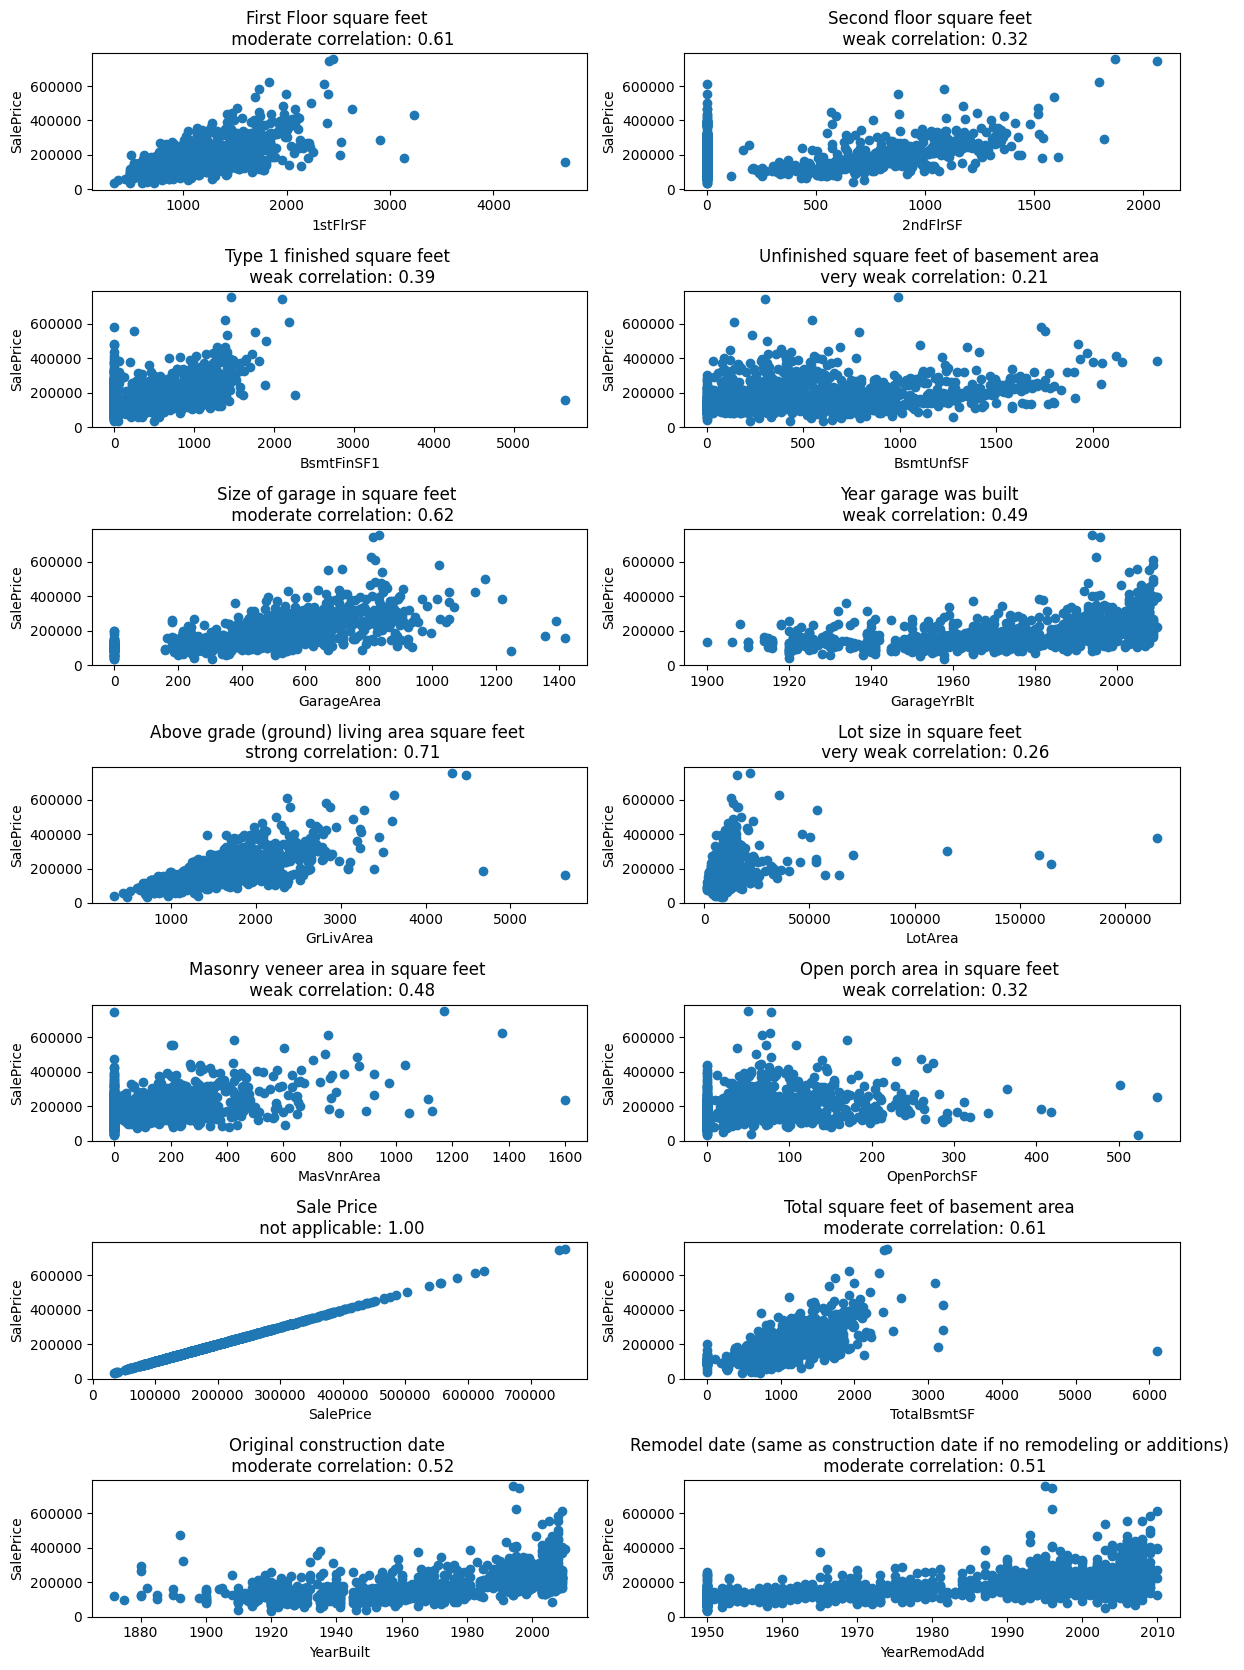

In [26]:
fig, axs = plt.subplots(int(numerical_column_count/plot_columns), plot_columns, figsize = (12, 1.2 * numerical_column_count))
for idx, var in enumerate(numerical_columns):
    ax = axs[int(idx/2)][idx%2]
    ax.scatter(housing_records[var], sale_prices)
    corr_value, corr_description = correlation_info[var]
    ax.set_title(f"{column_descriptions[var]} \n {corr_description}: {corr_value:.2f}")
    ax.set_ylabel(target_variable)
    ax.set_xlabel(var)
    
plt.tight_layout()
plt.show()

In [27]:
correlated_numerical_variables = []
for key, (value, desc) in correlation_info.items():
    if desc == "moderate correlation":
        correlated_numerical_variables.append(key)
            
correlated_numerical_variables

['GarageArea', 'TotalBsmtSF', '1stFlrSF', 'YearBuilt', 'YearRemodAdd']

In [28]:
correlated_numerical_variables

['GarageArea', 'TotalBsmtSF', '1stFlrSF', 'YearBuilt', 'YearRemodAdd']

## 2.3 Co-variance of SalePrice with categorical variables

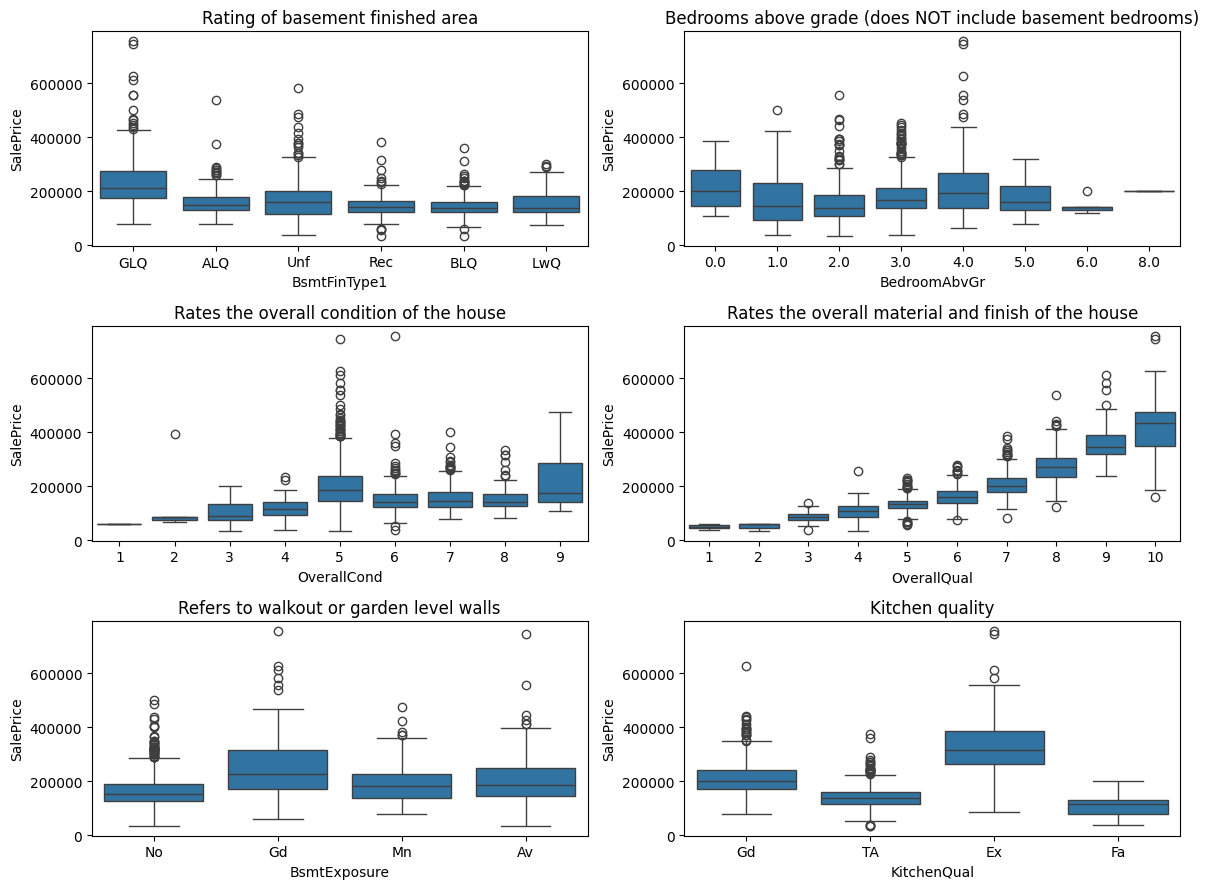

In [29]:
categorical_column_count = len(categorical_columns) 
fig, axs = plt.subplots(int(categorical_column_count/plot_columns), plot_columns, figsize = (12, 1.5 * categorical_column_count))
for idx, var in enumerate(categorical_columns):
    ax = axs[int(idx / 2)][idx % 2]
    sns.boxplot(ax=ax, x=housing_records[var], y=sale_prices)
    ax.set_title(f"{column_descriptions[var]}")
    ax.set_ylabel(target_variable)
    ax.set_xlabel(var)
    
plt.tight_layout()
plt.show()

Visually analysing the categorical data against category data definitions, 
one can conclude that "KitchenQual", "OverallCond", and "OverallQual" correlates strongly to target variable "SalePrice"

In [30]:
correlated_categorical_variables = ["KitchenQual", "OverallCond", "OverallQual"]

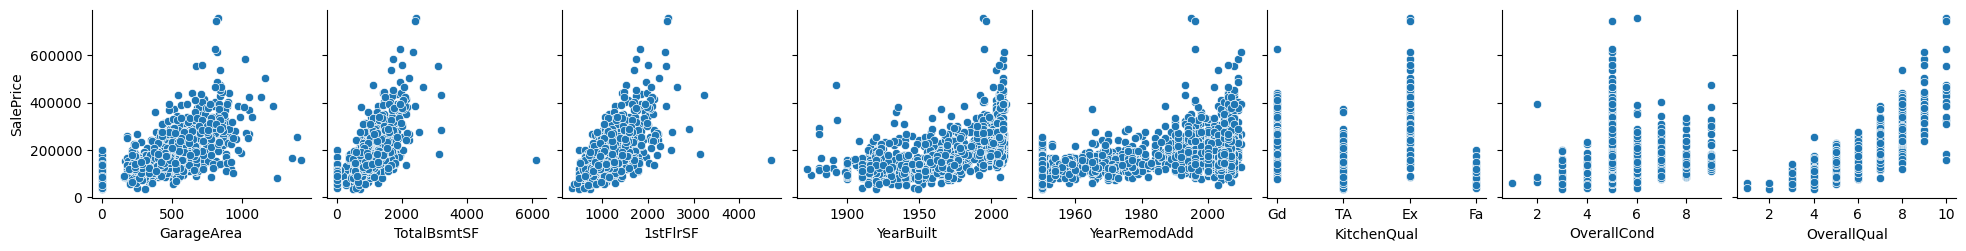

In [31]:
correlated_variables = correlated_numerical_variables + correlated_categorical_variables

sns.pairplot(
    data=housing_records,
    y_vars="SalePrice",
    x_vars=correlated_variables
)
plt.show()

# Conclusion and Next Step

* If you do not need to push files to Repo, you may replace this section with "Conclusions and Next Steps" and state your conclusions and next steps.